In [ ]:
#%%

import warnings
warnings.filterwarnings("ignore")
def action_with_warnings():
    warnings.warn("should not appear")
with warnings.catch_warnings(record=True):
    action_with_warnings()
import norgatedata
import quantstats        as qs
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt


pd.options.display.float_format = '{:.4}'.format

[2024-04-18 09:00:30.079648] INFO: Norgate Data: NorgateData package v1.0.74: Init complete


In [ ]:
#%%

start_date = "2000-01-01"

assets = ['SPY', 'AGG']

def download_history(symbol, start_date):
    return norgatedata.price_timeseries(
        symbol,
        stock_price_adjustment_setting = norgatedata.StockPriceAdjustmentType.TOTALRETURN,
        padding_setting                = norgatedata.PaddingType.NONE,
        start_date                     = start_date,
        timeseriesformat               = 'pandas-dataframe',
        )


prices_df = pd.DataFrame()
for symbol in assets:
    prices_df[symbol] = download_history(symbol, start_date)['Close']
prices_df.dropna(inplace=True)

returns_df = pd.DataFrame(index=prices_df.index)
for symbol in assets:
    returns_df[symbol] = prices_df[symbol].pct_change()
returns_df.dropna(inplace=True)

prices_df

,SPY,AGG
Date,,
2003-09-26,67.64,54.02
2003-09-29,68.3,53.87
2003-09-30,67.64,54.15
2003-10-01,69.08,54.12
2003-10-02,69.33,54.04
...,...,...
2024-04-11,518.0,95.78
2024-04-12,510.9,95.96
2024-04-15,504.5,95.38


In [ ]:
#%%

returns_df

,SPY,AGG
Date,,
2003-09-29,0.009805,-0.002733
2003-09-30,-0.00971,0.005187
2003-10-01,0.02131,-0.0004868
2003-10-02,0.003625,-0.001559
2003-10-03,0.009175,-0.00722
...,...,...
2024-04-11,0.007547,0.0002089
2024-04-12,-0.0138,0.001879
2024-04-15,-0.01253,-0.006044


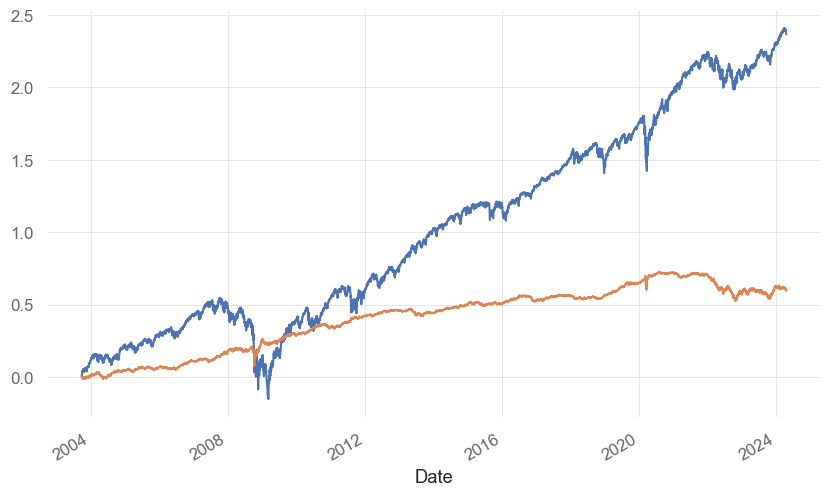

In [ ]:
#%%

returns_df.cumsum().plot(legend=False)
plt.show();

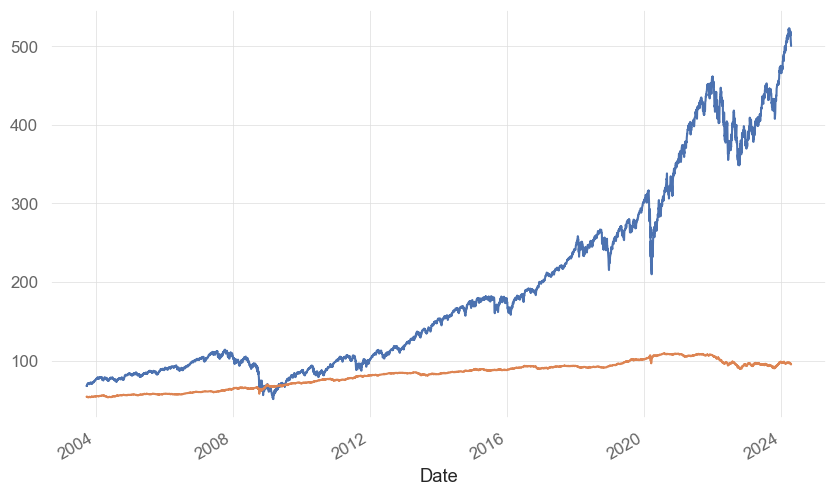

In [ ]:
#%%

prices_df.plot(legend=False)
plt.show();

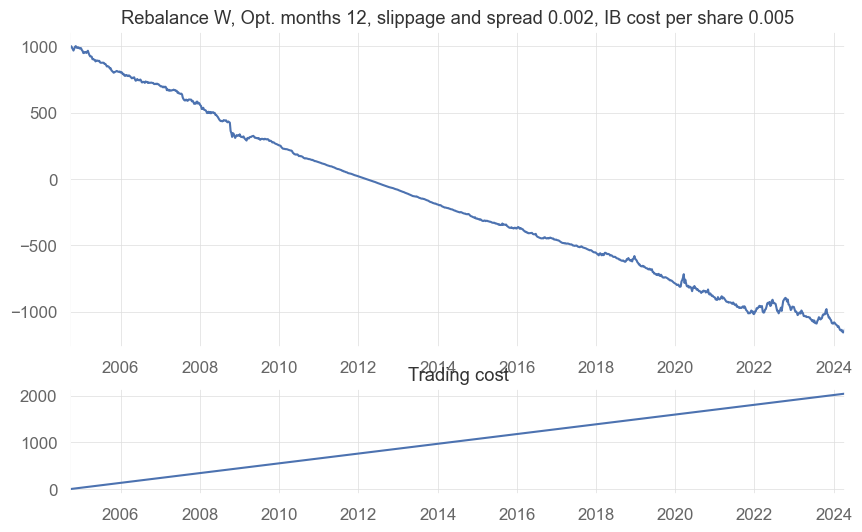

In [ ]:
#%%

portfolio_value      = 1000
rebalance_frequency  = "W"
optimization_months  = 12
cost_ib_per_shares   = 0.005  # USD per share https://www.interactivebrokers.com/en/pricing/commissions-home.php
cost_slippage_spread = 0.002  # Other cost
debug                = False

optimization_window  = pd.Timedelta(days=optimization_months*30) # approximately many months
dataset_start        = prices_df.index[0]
optimization_dates   = []
portfolio_values     = []
rebalancing_costs    = []

for group_start_date, group_data in prices_df.groupby(pd.Grouper(freq=rebalance_frequency)):

    if (group_start_date-dataset_start)<optimization_window:
        continue

    # Forecast section
    optimization_prices_df  = prices_df[group_start_date-optimization_window:group_start_date].copy()
    optimization_returns_df = optimization_prices_df.copy().pct_change()
    optimization_returns_df.dropna(inplace=True)

    if debug:
        print(f"[{group_start_date-optimization_window} - {group_start_date}]", end='  ')
    
    # Number of shares calculation
    w = pd.DataFrame(index=['SPY', 'AGG'])
    w['weight'           ] = [0.6, 0.4]
    w['investment_amount'] = w['weight'] * portfolio_value
    w['last_price'       ] = optimization_prices_df.iloc[-1]
    w['shares'           ] = round((w.investment_amount/w.last_price), 6)

    # Interactive Brokers dollar cost approximation MAX(1, 0.005*shares)
    w['shares_value'     ] = w['shares'] * w['last_price']
    w['ib_cost_value'    ] = w['shares'       ] * cost_ib_per_shares
    w['ib_cost_value'    ] = w['ib_cost_value'].apply(lambda x: max(1.0, x))
    total_ib_cost = w['ib_cost_value'].sum()

    if debug:
        print(f"pre ${round(w['shares_value'].sum(),2)}, cost ${round(total_ib_cost, 2)}", end=' -> ')


    # Evaluation section
    group_prices_df    = group_data.copy()
    group_returns_df   = group_prices_df.copy().pct_change()
    group_returns_df.dropna(inplace=True)

    if len(group_returns_df)<=0:
        continue

    group_equity_df    = group_returns_df.cumsum()
    group_returns_df   = group_equity_df - cost_slippage_spread

    group_end_returns  = group_returns_df.iloc[-1]
    group_values       = w['shares_value'] + w['shares_value']*group_end_returns

    portfolio_value    = group_values.sum() - total_ib_cost

    if debug:
        print(f"value ${round(portfolio_value,2)}")

    optimization_dates.append(group_start_date)
    portfolio_values.append(portfolio_value)
    rebalancing_costs.append(total_ib_cost)

    pass


portfolio_df = pd.DataFrame(index=optimization_dates)
portfolio_df['value'   ] = portfolio_values
portfolio_df['cost'    ] = rebalancing_costs
portfolio_df['cost_cum'] = portfolio_df['cost'].cumsum()

fig, axes = plt.subplots(nrows=2, height_ratios=[3, 1])
axes[0].set_title(f"Rebalance {rebalance_frequency}, Opt. months {optimization_months}, slippage and spread {cost_slippage_spread}, IB cost per share {cost_ib_per_shares}")
portfolio_df['value'   ].plot(ax=axes[0])
axes[1].set_title("Trading cost")
portfolio_df['cost_cum'].plot(ax=axes[1])
plt.show();

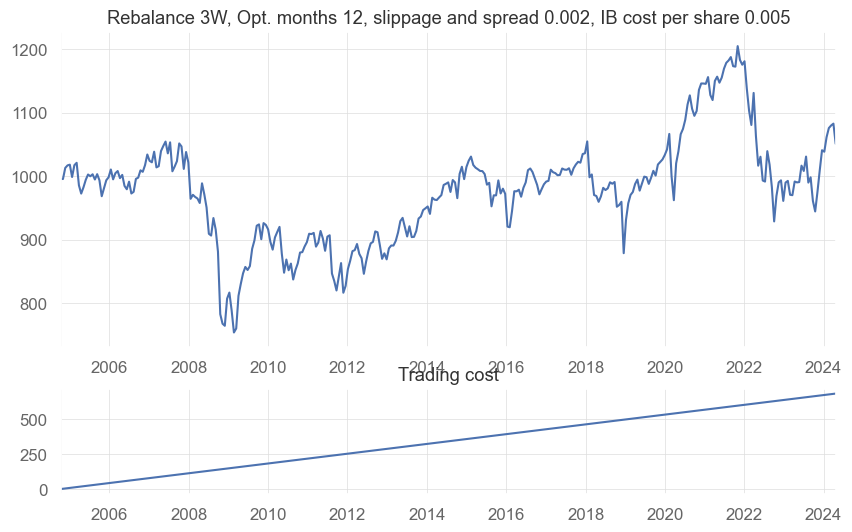

In [ ]:
#%%

portfolio_value      = 1000
rebalance_frequency  = "3W"
optimization_months  = 12
cost_ib_per_shares   = 0.005  # USD per share https://www.interactivebrokers.com/en/pricing/commissions-home.php
cost_slippage_spread = 0.002  # Other cost
debug                = False

optimization_window  = pd.Timedelta(days=optimization_months*30) # approximately many months
dataset_start        = prices_df.index[0]
optimization_dates   = []
portfolio_values     = []
rebalancing_costs    = []

for group_start_date, group_data in prices_df.groupby(pd.Grouper(freq=rebalance_frequency)):

    if (group_start_date-dataset_start)<optimization_window:
        continue

    # Forecast section
    optimization_prices_df  = prices_df[group_start_date-optimization_window:group_start_date].copy()
    optimization_returns_df = optimization_prices_df.copy().pct_change()
    optimization_returns_df.dropna(inplace=True)

    if debug:
        print(f"[{group_start_date-optimization_window} - {group_start_date}]", end='  ')
    
    # Number of shares calculation
    w = pd.DataFrame(index=['SPY', 'AGG'])
    w['weight'           ] = [0.6, 0.4]
    w['investment_amount'] = w['weight'] * portfolio_value
    w['last_price'       ] = optimization_prices_df.iloc[-1]
    w['shares'           ] = round((w.investment_amount/w.last_price), 6)

    # Interactive Brokers dollar cost approximation MAX(1, 0.005*shares)
    w['shares_value'     ] = w['shares'] * w['last_price']
    w['ib_cost_value'    ] = w['shares'       ] * cost_ib_per_shares
    w['ib_cost_value'    ] = w['ib_cost_value'].apply(lambda x: max(1.0, x))
    total_ib_cost = w['ib_cost_value'].sum()

    if debug:
        print(f"pre ${round(w['shares_value'].sum(),2)}, cost ${round(total_ib_cost, 2)}", end=' -> ')


    # Evaluation section
    group_prices_df    = group_data.copy()
    group_returns_df   = group_prices_df.copy().pct_change()
    group_returns_df.dropna(inplace=True)

    if len(group_returns_df)<=0:
        continue

    group_equity_df    = group_returns_df.cumsum()
    group_returns_df   = group_equity_df - cost_slippage_spread

    group_end_returns  = group_returns_df.iloc[-1]
    group_values       = w['shares_value'] + w['shares_value']*group_end_returns

    portfolio_value    = group_values.sum() - total_ib_cost

    if debug:
        print(f"value ${round(portfolio_value,2)}")

    optimization_dates.append(group_start_date)
    portfolio_values.append(portfolio_value)
    rebalancing_costs.append(total_ib_cost)

    pass


portfolio_df = pd.DataFrame(index=optimization_dates)
portfolio_df['value'   ] = portfolio_values
portfolio_df['cost'    ] = rebalancing_costs
portfolio_df['cost_cum'] = portfolio_df['cost'].cumsum()

fig, axes = plt.subplots(nrows=2, height_ratios=[3, 1])
axes[0].set_title(f"Rebalance {rebalance_frequency}, Opt. months {optimization_months}, slippage and spread {cost_slippage_spread}, IB cost per share {cost_ib_per_shares}")
portfolio_df['value'   ].plot(ax=axes[0])
axes[1].set_title("Trading cost")
portfolio_df['cost_cum'].plot(ax=axes[1])
plt.show();

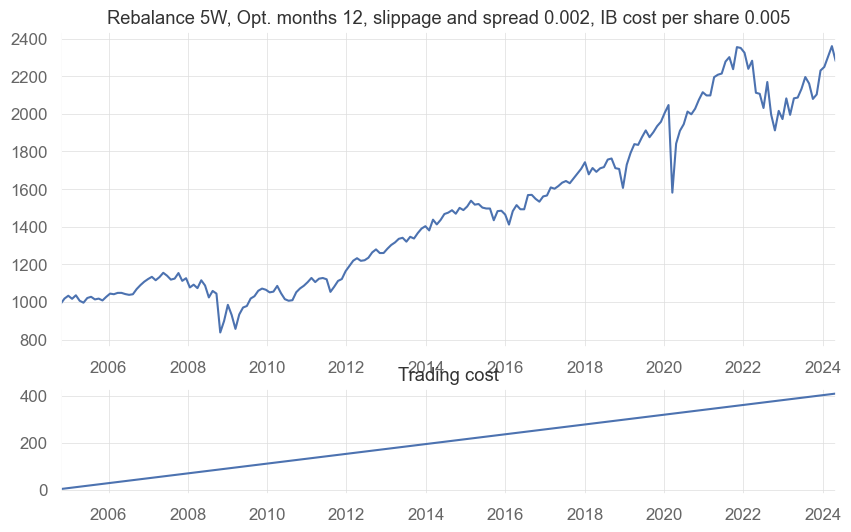

In [ ]:
#%%

portfolio_value      = 1000
rebalance_frequency  = "5W"
optimization_months  = 12
cost_ib_per_shares   = 0.005  # USD per share https://www.interactivebrokers.com/en/pricing/commissions-home.php
cost_slippage_spread = 0.002  # Other cost
debug                = False

optimization_window  = pd.Timedelta(days=optimization_months*30) # approximately many months
dataset_start        = prices_df.index[0]
optimization_dates   = []
portfolio_values     = []
rebalancing_costs    = []

for group_start_date, group_data in prices_df.groupby(pd.Grouper(freq=rebalance_frequency)):

    if (group_start_date-dataset_start)<optimization_window:
        continue

    # Forecast section
    optimization_prices_df  = prices_df[group_start_date-optimization_window:group_start_date].copy()
    optimization_returns_df = optimization_prices_df.copy().pct_change()
    optimization_returns_df.dropna(inplace=True)

    if debug:
        print(f"[{group_start_date-optimization_window} - {group_start_date}]", end='  ')
    
    # Number of shares calculation
    w = pd.DataFrame(index=['SPY', 'AGG'])
    w['weight'           ] = [0.6, 0.4]
    w['investment_amount'] = w['weight'] * portfolio_value
    w['last_price'       ] = optimization_prices_df.iloc[-1]
    w['shares'           ] = round((w.investment_amount/w.last_price), 6)

    # Interactive Brokers dollar cost approximation MAX(1, 0.005*shares)
    w['shares_value'     ] = w['shares'] * w['last_price']
    w['ib_cost_value'    ] = w['shares'       ] * cost_ib_per_shares
    w['ib_cost_value'    ] = w['ib_cost_value'].apply(lambda x: max(1.0, x))
    total_ib_cost = w['ib_cost_value'].sum()

    if debug:
        print(f"pre ${round(w['shares_value'].sum(),2)}, cost ${round(total_ib_cost, 2)}", end=' -> ')


    # Evaluation section
    group_prices_df    = group_data.copy()
    group_returns_df   = group_prices_df.copy().pct_change()
    group_returns_df.dropna(inplace=True)

    if len(group_returns_df)<=0:
        continue

    group_equity_df    = group_returns_df.cumsum()
    group_returns_df   = group_equity_df - cost_slippage_spread

    group_end_returns  = group_returns_df.iloc[-1]
    group_values       = w['shares_value'] + w['shares_value']*group_end_returns

    portfolio_value    = group_values.sum() - total_ib_cost

    if debug:
        print(f"value ${round(portfolio_value,2)}")

    optimization_dates.append(group_start_date)
    portfolio_values.append(portfolio_value)
    rebalancing_costs.append(total_ib_cost)

    pass


portfolio_df = pd.DataFrame(index=optimization_dates)
portfolio_df['value'   ] = portfolio_values
portfolio_df['cost'    ] = rebalancing_costs
portfolio_df['cost_cum'] = portfolio_df['cost'].cumsum()

fig, axes = plt.subplots(nrows=2, height_ratios=[3, 1])
axes[0].set_title(f"Rebalance {rebalance_frequency}, Opt. months {optimization_months}, slippage and spread {cost_slippage_spread}, IB cost per share {cost_ib_per_shares}")
portfolio_df['value'   ].plot(ax=axes[0])
axes[1].set_title("Trading cost")
portfolio_df['cost_cum'].plot(ax=axes[1])
plt.show();

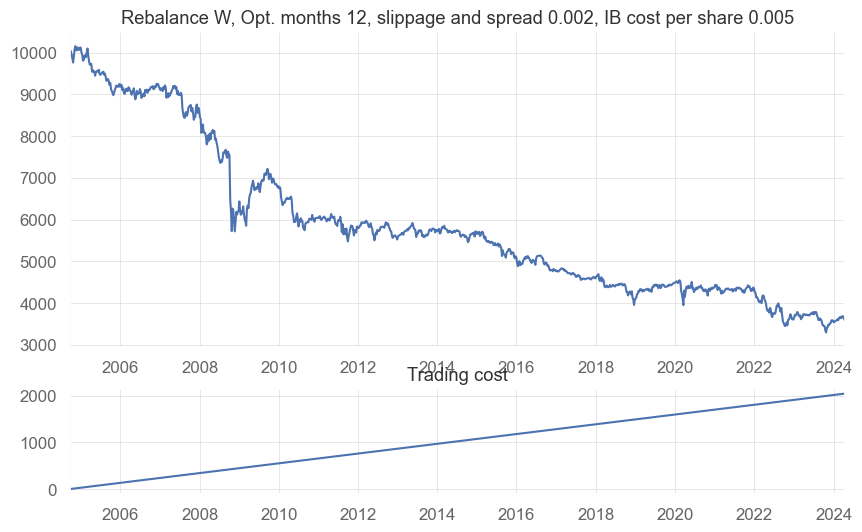

In [ ]:
#%%

portfolio_value      = 10000
rebalance_frequency  = "W"
optimization_months  = 12
cost_ib_per_shares   = 0.005  # USD per share https://www.interactivebrokers.com/en/pricing/commissions-home.php
cost_slippage_spread = 0.002  # Other cost
debug                = False

optimization_window  = pd.Timedelta(days=optimization_months*30) # approximately many months
dataset_start        = prices_df.index[0]
optimization_dates   = []
portfolio_values     = []
rebalancing_costs    = []

for group_start_date, group_data in prices_df.groupby(pd.Grouper(freq=rebalance_frequency)):

    if (group_start_date-dataset_start)<optimization_window:
        continue

    # Forecast section
    optimization_prices_df  = prices_df[group_start_date-optimization_window:group_start_date].copy()
    optimization_returns_df = optimization_prices_df.copy().pct_change()
    optimization_returns_df.dropna(inplace=True)

    if debug:
        print(f"[{group_start_date-optimization_window} - {group_start_date}]", end='  ')
    
    # Number of shares calculation
    w = pd.DataFrame(index=['SPY', 'AGG'])
    w['weight'           ] = [0.6, 0.4]
    w['investment_amount'] = w['weight'] * portfolio_value
    w['last_price'       ] = optimization_prices_df.iloc[-1]
    w['shares'           ] = round((w.investment_amount/w.last_price), 6)

    # Interactive Brokers dollar cost approximation MAX(1, 0.005*shares)
    w['shares_value'     ] = w['shares'] * w['last_price']
    w['ib_cost_value'    ] = w['shares'       ] * cost_ib_per_shares
    w['ib_cost_value'    ] = w['ib_cost_value'].apply(lambda x: max(1.0, x))
    total_ib_cost = w['ib_cost_value'].sum()

    if debug:
        print(f"pre ${round(w['shares_value'].sum(),2)}, cost ${round(total_ib_cost, 2)}", end=' -> ')


    # Evaluation section
    group_prices_df    = group_data.copy()
    group_returns_df   = group_prices_df.copy().pct_change()
    group_returns_df.dropna(inplace=True)

    if len(group_returns_df)<=0:
        continue

    group_equity_df    = group_returns_df.cumsum()
    group_returns_df   = group_equity_df - cost_slippage_spread

    group_end_returns  = group_returns_df.iloc[-1]
    group_values       = w['shares_value'] + w['shares_value']*group_end_returns

    portfolio_value    = group_values.sum() - total_ib_cost

    if debug:
        print(f"value ${round(portfolio_value,2)}")

    optimization_dates.append(group_start_date)
    portfolio_values.append(portfolio_value)
    rebalancing_costs.append(total_ib_cost)

    pass


portfolio_df = pd.DataFrame(index=optimization_dates)
portfolio_df['value'   ] = portfolio_values
portfolio_df['cost'    ] = rebalancing_costs
portfolio_df['cost_cum'] = portfolio_df['cost'].cumsum()

fig, axes = plt.subplots(nrows=2, height_ratios=[3, 1])
axes[0].set_title(f"Rebalance {rebalance_frequency}, Opt. months {optimization_months}, slippage and spread {cost_slippage_spread}, IB cost per share {cost_ib_per_shares}")
portfolio_df['value'   ].plot(ax=axes[0])
axes[1].set_title("Trading cost")
portfolio_df['cost_cum'].plot(ax=axes[1])
plt.show();

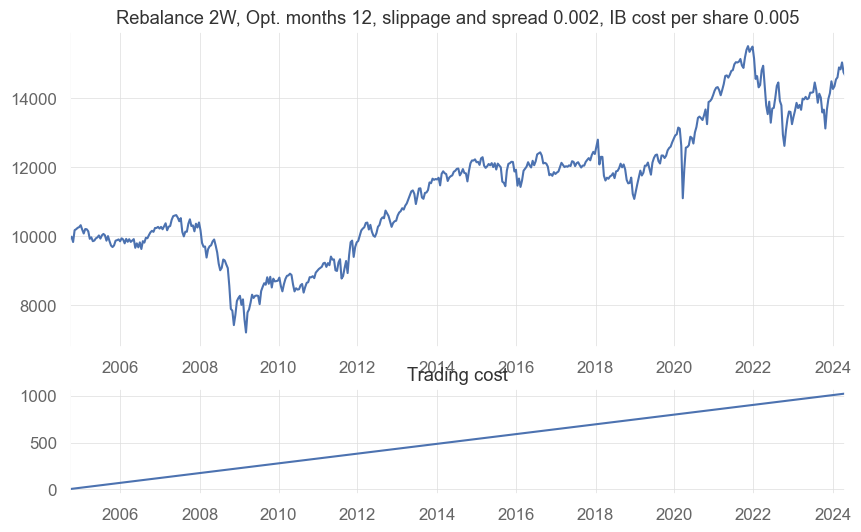

In [ ]:
#%%

portfolio_value      = 10000
rebalance_frequency  = "2W"
optimization_months  = 12
cost_ib_per_shares   = 0.005  # USD per share https://www.interactivebrokers.com/en/pricing/commissions-home.php
cost_slippage_spread = 0.002  # Other cost
debug                = False

optimization_window  = pd.Timedelta(days=optimization_months*30) # approximately many months
dataset_start        = prices_df.index[0]
optimization_dates   = []
portfolio_values     = []
rebalancing_costs    = []

for group_start_date, group_data in prices_df.groupby(pd.Grouper(freq=rebalance_frequency)):

    if (group_start_date-dataset_start)<optimization_window:
        continue

    # Forecast section
    optimization_prices_df  = prices_df[group_start_date-optimization_window:group_start_date].copy()
    optimization_returns_df = optimization_prices_df.copy().pct_change()
    optimization_returns_df.dropna(inplace=True)

    if debug:
        print(f"[{group_start_date-optimization_window} - {group_start_date}]", end='  ')
    
    # Number of shares calculation
    w = pd.DataFrame(index=['SPY', 'AGG'])
    w['weight'           ] = [0.6, 0.4]
    w['investment_amount'] = w['weight'] * portfolio_value
    w['last_price'       ] = optimization_prices_df.iloc[-1]
    w['shares'           ] = round((w.investment_amount/w.last_price), 6)

    # Interactive Brokers dollar cost approximation MAX(1, 0.005*shares)
    w['shares_value'     ] = w['shares'] * w['last_price']
    w['ib_cost_value'    ] = w['shares'       ] * cost_ib_per_shares
    w['ib_cost_value'    ] = w['ib_cost_value'].apply(lambda x: max(1.0, x))
    total_ib_cost = w['ib_cost_value'].sum()

    if debug:
        print(f"pre ${round(w['shares_value'].sum(),2)}, cost ${round(total_ib_cost, 2)}", end=' -> ')


    # Evaluation section
    group_prices_df    = group_data.copy()
    group_returns_df   = group_prices_df.copy().pct_change()
    group_returns_df.dropna(inplace=True)

    if len(group_returns_df)<=0:
        continue

    group_equity_df    = group_returns_df.cumsum()
    group_returns_df   = group_equity_df - cost_slippage_spread

    group_end_returns  = group_returns_df.iloc[-1]
    group_values       = w['shares_value'] + w['shares_value']*group_end_returns

    portfolio_value    = group_values.sum() - total_ib_cost

    if debug:
        print(f"value ${round(portfolio_value,2)}")

    optimization_dates.append(group_start_date)
    portfolio_values.append(portfolio_value)
    rebalancing_costs.append(total_ib_cost)

    pass


portfolio_df = pd.DataFrame(index=optimization_dates)
portfolio_df['value'   ] = portfolio_values
portfolio_df['cost'    ] = rebalancing_costs
portfolio_df['cost_cum'] = portfolio_df['cost'].cumsum()

fig, axes = plt.subplots(nrows=2, height_ratios=[3, 1])
axes[0].set_title(f"Rebalance {rebalance_frequency}, Opt. months {optimization_months}, slippage and spread {cost_slippage_spread}, IB cost per share {cost_ib_per_shares}")
portfolio_df['value'   ].plot(ax=axes[0])
axes[1].set_title("Trading cost")
portfolio_df['cost_cum'].plot(ax=axes[1])
plt.show();

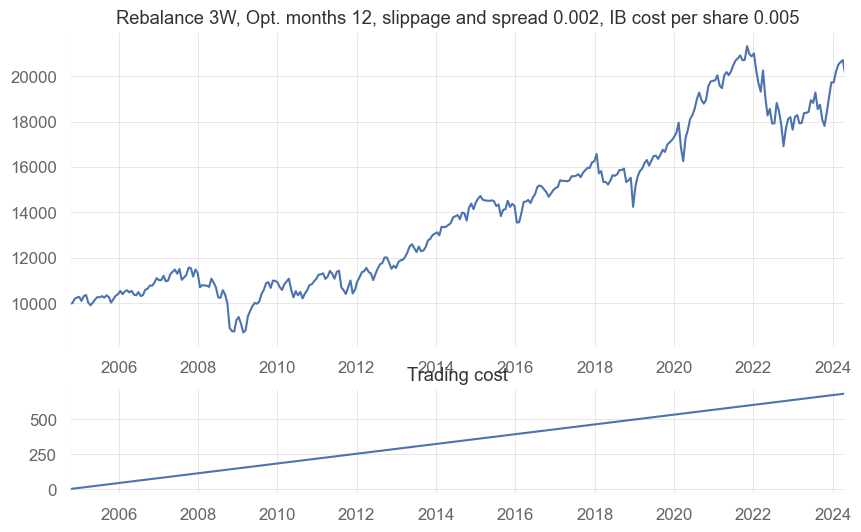

In [ ]:
#%%

portfolio_value      = 10000
rebalance_frequency  = "3W"
optimization_months  = 12
cost_ib_per_shares   = 0.005  # USD per share https://www.interactivebrokers.com/en/pricing/commissions-home.php
cost_slippage_spread = 0.002  # Other cost
debug                = False

optimization_window  = pd.Timedelta(days=optimization_months*30) # approximately many months
dataset_start        = prices_df.index[0]
optimization_dates   = []
portfolio_values     = []
rebalancing_costs    = []

for group_start_date, group_data in prices_df.groupby(pd.Grouper(freq=rebalance_frequency)):

    if (group_start_date-dataset_start)<optimization_window:
        continue

    # Forecast section
    optimization_prices_df  = prices_df[group_start_date-optimization_window:group_start_date].copy()
    optimization_returns_df = optimization_prices_df.copy().pct_change()
    optimization_returns_df.dropna(inplace=True)

    if debug:
        print(f"[{group_start_date-optimization_window} - {group_start_date}]", end='  ')
    
    # Number of shares calculation
    w = pd.DataFrame(index=['SPY', 'AGG'])
    w['weight'           ] = [0.6, 0.4]
    w['investment_amount'] = w['weight'] * portfolio_value
    w['last_price'       ] = optimization_prices_df.iloc[-1]
    w['shares'           ] = round((w.investment_amount/w.last_price), 6)

    # Interactive Brokers dollar cost approximation MAX(1, 0.005*shares)
    w['shares_value'     ] = w['shares'] * w['last_price']
    w['ib_cost_value'    ] = w['shares'       ] * cost_ib_per_shares
    w['ib_cost_value'    ] = w['ib_cost_value'].apply(lambda x: max(1.0, x))
    total_ib_cost = w['ib_cost_value'].sum()

    if debug:
        print(f"pre ${round(w['shares_value'].sum(),2)}, cost ${round(total_ib_cost, 2)}", end=' -> ')


    # Evaluation section
    group_prices_df    = group_data.copy()
    group_returns_df   = group_prices_df.copy().pct_change()
    group_returns_df.dropna(inplace=True)

    if len(group_returns_df)<=0:
        continue

    group_equity_df    = group_returns_df.cumsum()
    group_returns_df   = group_equity_df - cost_slippage_spread

    group_end_returns  = group_returns_df.iloc[-1]
    group_values       = w['shares_value'] + w['shares_value']*group_end_returns

    portfolio_value    = group_values.sum() - total_ib_cost

    if debug:
        print(f"value ${round(portfolio_value,2)}")

    optimization_dates.append(group_start_date)
    portfolio_values.append(portfolio_value)
    rebalancing_costs.append(total_ib_cost)

    pass


portfolio_df = pd.DataFrame(index=optimization_dates)
portfolio_df['value'   ] = portfolio_values
portfolio_df['cost'    ] = rebalancing_costs
portfolio_df['cost_cum'] = portfolio_df['cost'].cumsum()

fig, axes = plt.subplots(nrows=2, height_ratios=[3, 1])
axes[0].set_title(f"Rebalance {rebalance_frequency}, Opt. months {optimization_months}, slippage and spread {cost_slippage_spread}, IB cost per share {cost_ib_per_shares}")
portfolio_df['value'   ].plot(ax=axes[0])
axes[1].set_title("Trading cost")
portfolio_df['cost_cum'].plot(ax=axes[1])
plt.show();

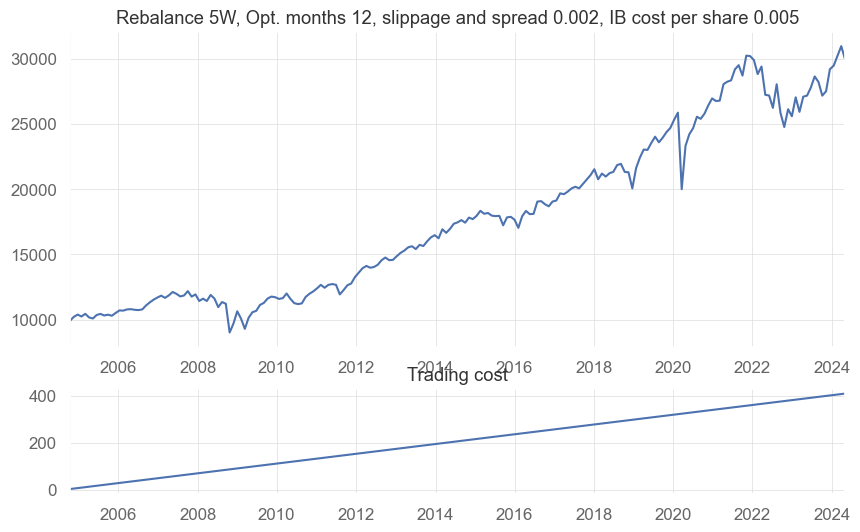

In [ ]:
#%%

portfolio_value      = 10000
rebalance_frequency  = "5W"
optimization_months  = 12
cost_ib_per_shares   = 0.005  # USD per share https://www.interactivebrokers.com/en/pricing/commissions-home.php
cost_slippage_spread = 0.002  # Other cost
debug                = False

optimization_window  = pd.Timedelta(days=optimization_months*30) # approximately many months
dataset_start        = prices_df.index[0]
optimization_dates   = []
portfolio_values     = []
rebalancing_costs    = []

for group_start_date, group_data in prices_df.groupby(pd.Grouper(freq=rebalance_frequency)):

    if (group_start_date-dataset_start)<optimization_window:
        continue

    # Forecast section
    optimization_prices_df  = prices_df[group_start_date-optimization_window:group_start_date].copy()
    optimization_returns_df = optimization_prices_df.copy().pct_change()
    optimization_returns_df.dropna(inplace=True)

    if debug:
        print(f"[{group_start_date-optimization_window} - {group_start_date}]", end='  ')
    
    # Number of shares calculation
    w = pd.DataFrame(index=['SPY', 'AGG'])
    w['weight'           ] = [0.6, 0.4]
    w['investment_amount'] = w['weight'] * portfolio_value
    w['last_price'       ] = optimization_prices_df.iloc[-1]
    w['shares'           ] = round((w.investment_amount/w.last_price), 6)

    # Interactive Brokers dollar cost approximation MAX(1, 0.005*shares)
    w['shares_value'     ] = w['shares'] * w['last_price']
    w['ib_cost_value'    ] = w['shares'       ] * cost_ib_per_shares
    w['ib_cost_value'    ] = w['ib_cost_value'].apply(lambda x: max(1.0, x))
    total_ib_cost = w['ib_cost_value'].sum()

    if debug:
        print(f"pre ${round(w['shares_value'].sum(),2)}, cost ${round(total_ib_cost, 2)}", end=' -> ')


    # Evaluation section
    group_prices_df    = group_data.copy()
    group_returns_df   = group_prices_df.copy().pct_change()
    group_returns_df.dropna(inplace=True)

    if len(group_returns_df)<=0:
        continue

    group_equity_df    = group_returns_df.cumsum()
    group_returns_df   = group_equity_df - cost_slippage_spread

    group_end_returns  = group_returns_df.iloc[-1]
    group_values       = w['shares_value'] + w['shares_value']*group_end_returns

    portfolio_value    = group_values.sum() - total_ib_cost

    if debug:
        print(f"value ${round(portfolio_value,2)}")

    optimization_dates.append(group_start_date)
    portfolio_values.append(portfolio_value)
    rebalancing_costs.append(total_ib_cost)

    pass


portfolio_df = pd.DataFrame(index=optimization_dates)
portfolio_df['value'   ] = portfolio_values
portfolio_df['cost'    ] = rebalancing_costs
portfolio_df['cost_cum'] = portfolio_df['cost'].cumsum()

fig, axes = plt.subplots(nrows=2, height_ratios=[3, 1])
axes[0].set_title(f"Rebalance {rebalance_frequency}, Opt. months {optimization_months}, slippage and spread {cost_slippage_spread}, IB cost per share {cost_ib_per_shares}")
portfolio_df['value'   ].plot(ax=axes[0])
axes[1].set_title("Trading cost")
portfolio_df['cost_cum'].plot(ax=axes[1])
plt.show();

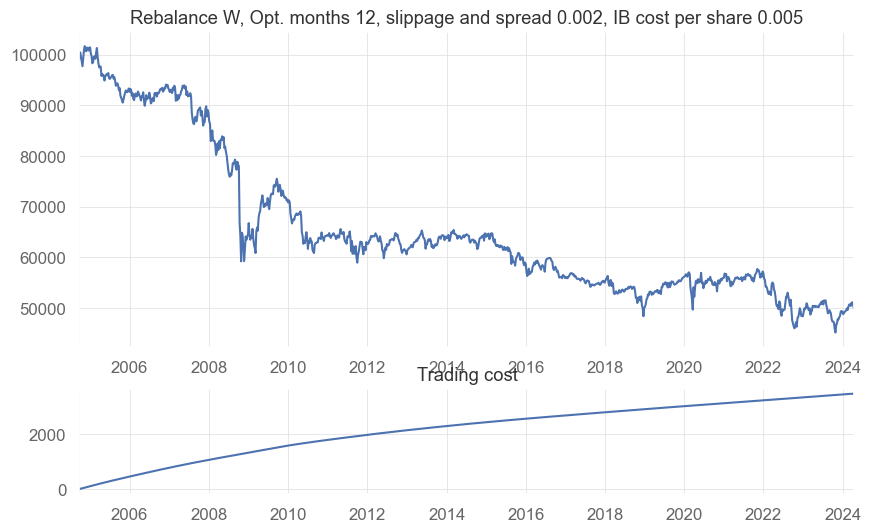

In [ ]:
#%%

portfolio_value      = 100000
rebalance_frequency  = "W"
optimization_months  = 12
cost_ib_per_shares   = 0.005  # USD per share https://www.interactivebrokers.com/en/pricing/commissions-home.php
cost_slippage_spread = 0.002  # Other cost
debug                = False

optimization_window  = pd.Timedelta(days=optimization_months*30) # approximately many months
dataset_start        = prices_df.index[0]
optimization_dates   = []
portfolio_values     = []
rebalancing_costs    = []

for group_start_date, group_data in prices_df.groupby(pd.Grouper(freq=rebalance_frequency)):

    if (group_start_date-dataset_start)<optimization_window:
        continue

    # Forecast section
    optimization_prices_df  = prices_df[group_start_date-optimization_window:group_start_date].copy()
    optimization_returns_df = optimization_prices_df.copy().pct_change()
    optimization_returns_df.dropna(inplace=True)

    if debug:
        print(f"[{group_start_date-optimization_window} - {group_start_date}]", end='  ')
    
    # Number of shares calculation
    w = pd.DataFrame(index=['SPY', 'AGG'])
    w['weight'           ] = [0.6, 0.4]
    w['investment_amount'] = w['weight'] * portfolio_value
    w['last_price'       ] = optimization_prices_df.iloc[-1]
    w['shares'           ] = round((w.investment_amount/w.last_price), 6)

    # Interactive Brokers dollar cost approximation MAX(1, 0.005*shares)
    w['shares_value'     ] = w['shares'] * w['last_price']
    w['ib_cost_value'    ] = w['shares'       ] * cost_ib_per_shares
    w['ib_cost_value'    ] = w['ib_cost_value'].apply(lambda x: max(1.0, x))
    total_ib_cost = w['ib_cost_value'].sum()

    if debug:
        print(f"pre ${round(w['shares_value'].sum(),2)}, cost ${round(total_ib_cost, 2)}", end=' -> ')


    # Evaluation section
    group_prices_df    = group_data.copy()
    group_returns_df   = group_prices_df.copy().pct_change()
    group_returns_df.dropna(inplace=True)

    if len(group_returns_df)<=0:
        continue

    group_equity_df    = group_returns_df.cumsum()
    group_returns_df   = group_equity_df - cost_slippage_spread

    group_end_returns  = group_returns_df.iloc[-1]
    group_values       = w['shares_value'] + w['shares_value']*group_end_returns

    portfolio_value    = group_values.sum() - total_ib_cost

    if debug:
        print(f"value ${round(portfolio_value,2)}")

    optimization_dates.append(group_start_date)
    portfolio_values.append(portfolio_value)
    rebalancing_costs.append(total_ib_cost)

    pass


portfolio_df = pd.DataFrame(index=optimization_dates)
portfolio_df['value'   ] = portfolio_values
portfolio_df['cost'    ] = rebalancing_costs
portfolio_df['cost_cum'] = portfolio_df['cost'].cumsum()

fig, axes = plt.subplots(nrows=2, height_ratios=[3, 1])
axes[0].set_title(f"Rebalance {rebalance_frequency}, Opt. months {optimization_months}, slippage and spread {cost_slippage_spread}, IB cost per share {cost_ib_per_shares}")
portfolio_df['value'   ].plot(ax=axes[0])
axes[1].set_title("Trading cost")
portfolio_df['cost_cum'].plot(ax=axes[1])
plt.show();

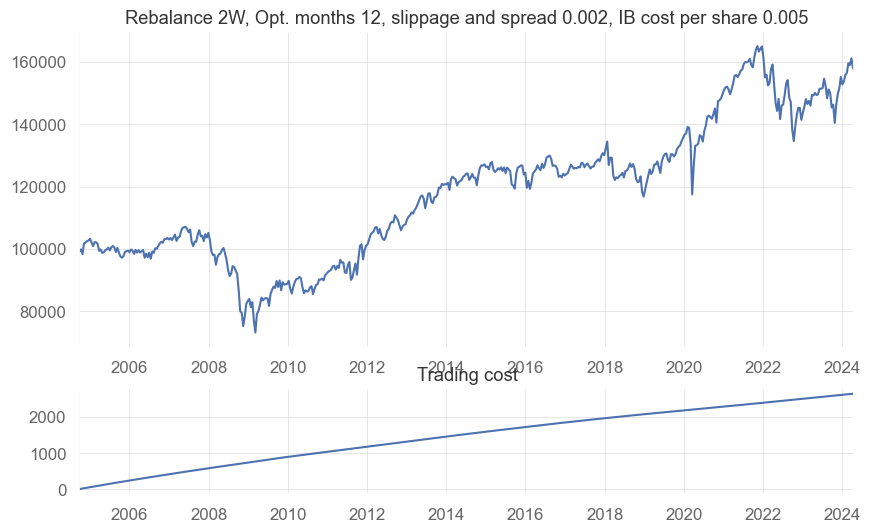

In [ ]:
#%%

portfolio_value      = 100000
rebalance_frequency  = "2W"
optimization_months  = 12
cost_ib_per_shares   = 0.005  # USD per share https://www.interactivebrokers.com/en/pricing/commissions-home.php
cost_slippage_spread = 0.002  # Other cost
debug                = False

optimization_window  = pd.Timedelta(days=optimization_months*30) # approximately many months
dataset_start        = prices_df.index[0]
optimization_dates   = []
portfolio_values     = []
rebalancing_costs    = []

for group_start_date, group_data in prices_df.groupby(pd.Grouper(freq=rebalance_frequency)):

    if (group_start_date-dataset_start)<optimization_window:
        continue

    # Forecast section
    optimization_prices_df  = prices_df[group_start_date-optimization_window:group_start_date].copy()
    optimization_returns_df = optimization_prices_df.copy().pct_change()
    optimization_returns_df.dropna(inplace=True)

    if debug:
        print(f"[{group_start_date-optimization_window} - {group_start_date}]", end='  ')
    
    # Number of shares calculation
    w = pd.DataFrame(index=['SPY', 'AGG'])
    w['weight'           ] = [0.6, 0.4]
    w['investment_amount'] = w['weight'] * portfolio_value
    w['last_price'       ] = optimization_prices_df.iloc[-1]
    w['shares'           ] = round((w.investment_amount/w.last_price), 6)

    # Interactive Brokers dollar cost approximation MAX(1, 0.005*shares)
    w['shares_value'     ] = w['shares'] * w['last_price']
    w['ib_cost_value'    ] = w['shares'       ] * cost_ib_per_shares
    w['ib_cost_value'    ] = w['ib_cost_value'].apply(lambda x: max(1.0, x))
    total_ib_cost = w['ib_cost_value'].sum()

    if debug:
        print(f"pre ${round(w['shares_value'].sum(),2)}, cost ${round(total_ib_cost, 2)}", end=' -> ')


    # Evaluation section
    group_prices_df    = group_data.copy()
    group_returns_df   = group_prices_df.copy().pct_change()
    group_returns_df.dropna(inplace=True)

    if len(group_returns_df)<=0:
        continue

    group_equity_df    = group_returns_df.cumsum()
    group_returns_df   = group_equity_df - cost_slippage_spread

    group_end_returns  = group_returns_df.iloc[-1]
    group_values       = w['shares_value'] + w['shares_value']*group_end_returns

    portfolio_value    = group_values.sum() - total_ib_cost

    if debug:
        print(f"value ${round(portfolio_value,2)}")

    optimization_dates.append(group_start_date)
    portfolio_values.append(portfolio_value)
    rebalancing_costs.append(total_ib_cost)

    pass


portfolio_df = pd.DataFrame(index=optimization_dates)
portfolio_df['value'   ] = portfolio_values
portfolio_df['cost'    ] = rebalancing_costs
portfolio_df['cost_cum'] = portfolio_df['cost'].cumsum()

fig, axes = plt.subplots(nrows=2, height_ratios=[3, 1])
axes[0].set_title(f"Rebalance {rebalance_frequency}, Opt. months {optimization_months}, slippage and spread {cost_slippage_spread}, IB cost per share {cost_ib_per_shares}")
portfolio_df['value'   ].plot(ax=axes[0])
axes[1].set_title("Trading cost")
portfolio_df['cost_cum'].plot(ax=axes[1])
plt.show();

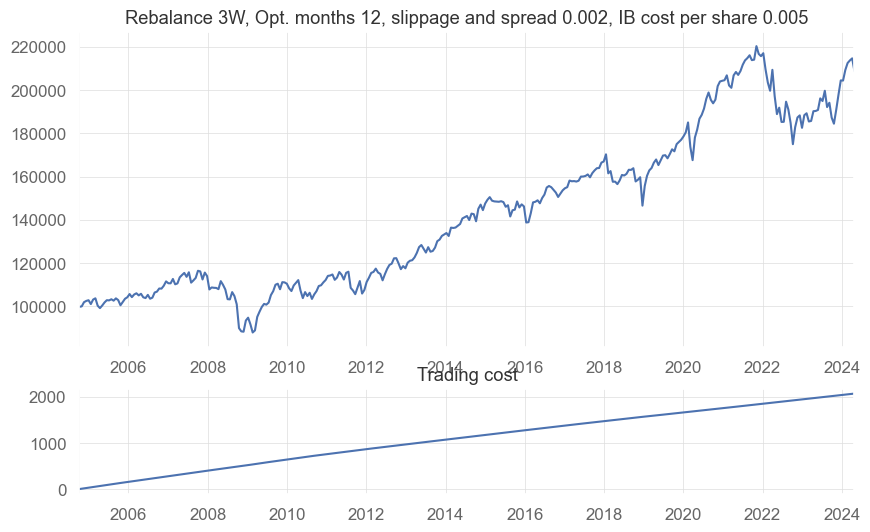

In [ ]:
#%%

portfolio_value      = 100000
rebalance_frequency  = "3W"
optimization_months  = 12
cost_ib_per_shares   = 0.005  # USD per share https://www.interactivebrokers.com/en/pricing/commissions-home.php
cost_slippage_spread = 0.002  # Other cost
debug                = False

optimization_window  = pd.Timedelta(days=optimization_months*30) # approximately many months
dataset_start        = prices_df.index[0]
optimization_dates   = []
portfolio_values     = []
rebalancing_costs    = []

for group_start_date, group_data in prices_df.groupby(pd.Grouper(freq=rebalance_frequency)):

    if (group_start_date-dataset_start)<optimization_window:
        continue

    # Forecast section
    optimization_prices_df  = prices_df[group_start_date-optimization_window:group_start_date].copy()
    optimization_returns_df = optimization_prices_df.copy().pct_change()
    optimization_returns_df.dropna(inplace=True)

    if debug:
        print(f"[{group_start_date-optimization_window} - {group_start_date}]", end='  ')
    
    # Number of shares calculation
    w = pd.DataFrame(index=['SPY', 'AGG'])
    w['weight'           ] = [0.6, 0.4]
    w['investment_amount'] = w['weight'] * portfolio_value
    w['last_price'       ] = optimization_prices_df.iloc[-1]
    w['shares'           ] = round((w.investment_amount/w.last_price), 6)

    # Interactive Brokers dollar cost approximation MAX(1, 0.005*shares)
    w['shares_value'     ] = w['shares'] * w['last_price']
    w['ib_cost_value'    ] = w['shares'       ] * cost_ib_per_shares
    w['ib_cost_value'    ] = w['ib_cost_value'].apply(lambda x: max(1.0, x))
    total_ib_cost = w['ib_cost_value'].sum()

    if debug:
        print(f"pre ${round(w['shares_value'].sum(),2)}, cost ${round(total_ib_cost, 2)}", end=' -> ')


    # Evaluation section
    group_prices_df    = group_data.copy()
    group_returns_df   = group_prices_df.copy().pct_change()
    group_returns_df.dropna(inplace=True)

    if len(group_returns_df)<=0:
        continue

    group_equity_df    = group_returns_df.cumsum()
    group_returns_df   = group_equity_df - cost_slippage_spread

    group_end_returns  = group_returns_df.iloc[-1]
    group_values       = w['shares_value'] + w['shares_value']*group_end_returns

    portfolio_value    = group_values.sum() - total_ib_cost

    if debug:
        print(f"value ${round(portfolio_value,2)}")

    optimization_dates.append(group_start_date)
    portfolio_values.append(portfolio_value)
    rebalancing_costs.append(total_ib_cost)

    pass


portfolio_df = pd.DataFrame(index=optimization_dates)
portfolio_df['value'   ] = portfolio_values
portfolio_df['cost'    ] = rebalancing_costs
portfolio_df['cost_cum'] = portfolio_df['cost'].cumsum()

fig, axes = plt.subplots(nrows=2, height_ratios=[3, 1])
axes[0].set_title(f"Rebalance {rebalance_frequency}, Opt. months {optimization_months}, slippage and spread {cost_slippage_spread}, IB cost per share {cost_ib_per_shares}")
portfolio_df['value'   ].plot(ax=axes[0])
axes[1].set_title("Trading cost")
portfolio_df['cost_cum'].plot(ax=axes[1])
plt.show();

                           Strategy
-------------------------  ----------
Start Period               2004-10-31
End Period                 2024-04-28
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          109.15%
CAGR﹪                     2.65%

Sharpe                     1.74
Prob. Sharpe Ratio         97.32%
Smart Sharpe               1.71
Sortino                    2.4
Smart Sortino              2.36
Sortino/√2                 1.7
Smart Sortino/√2           1.67
Omega                      1.34

Max Drawdown               -24.5%
Longest DD Days            1597
Volatility (ann.)          34.94%
Calmar                     0.11
Skew                       -0.84
Kurtosis                   2.76

Expected Daily %           0.22%
Expected Monthly %         0.31%
Expected Yearly %          3.58%
Kelly Criterion            16.32%
Risk of Ruin               0.0%
Daily Value-at-Risk        -3.38%
Expected Shortfall (cVaR)  -3.38%

Max Consecutive Wins      

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2007-10-28,2009-02-22,2012-03-11,1597,-24.5,-24.19
2,2021-11-28,2022-10-09,2024-04-28,883,-20.57,-17.15
3,2018-02-11,2018-12-23,2019-08-11,547,-13.93,-8.602
4,2020-03-08,2020-03-29,2020-05-10,64,-9.414,-6.076
5,2015-03-08,2016-01-17,2016-06-12,463,-7.802,-7.707


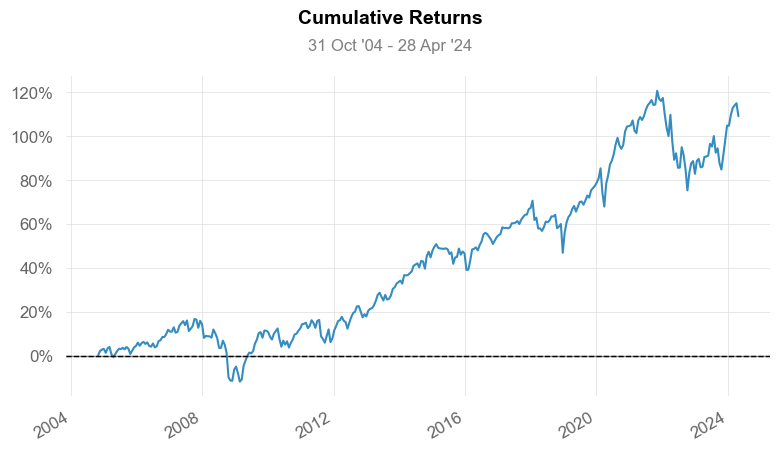

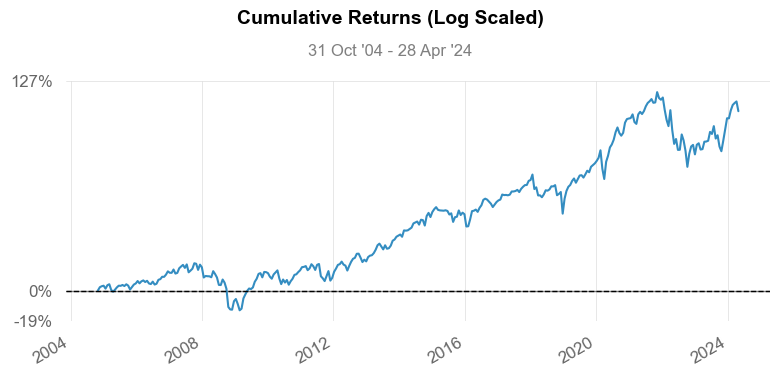

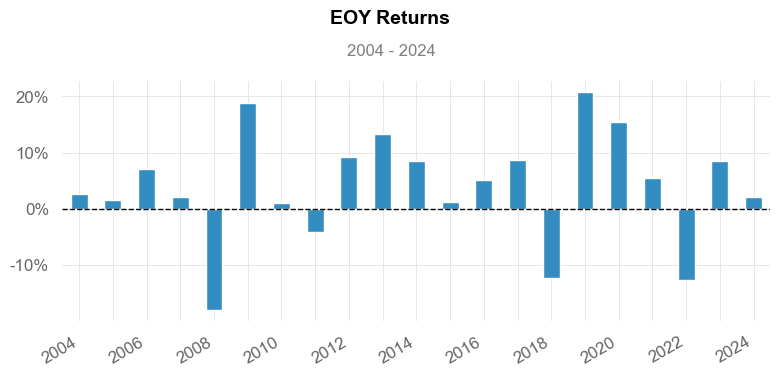

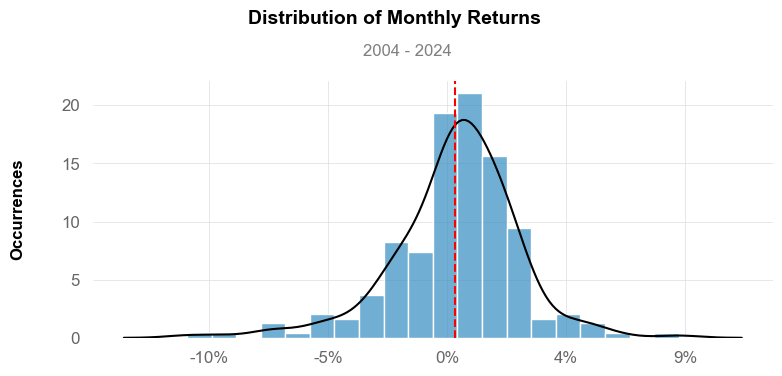

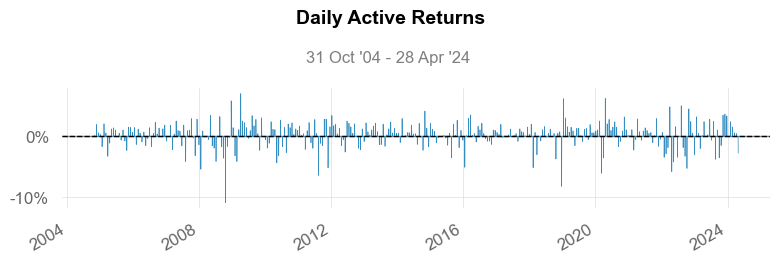

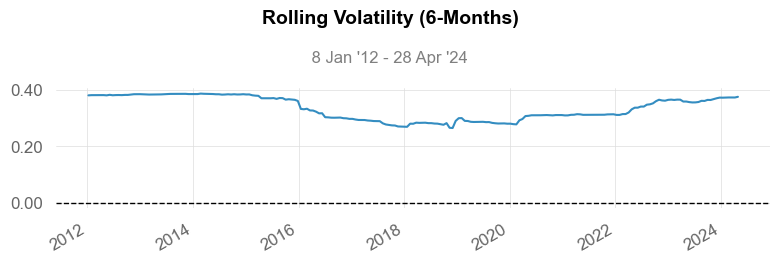

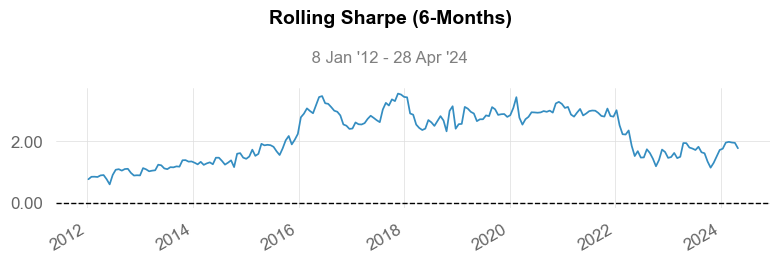

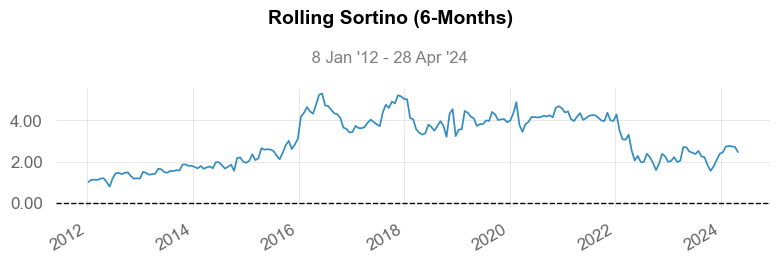

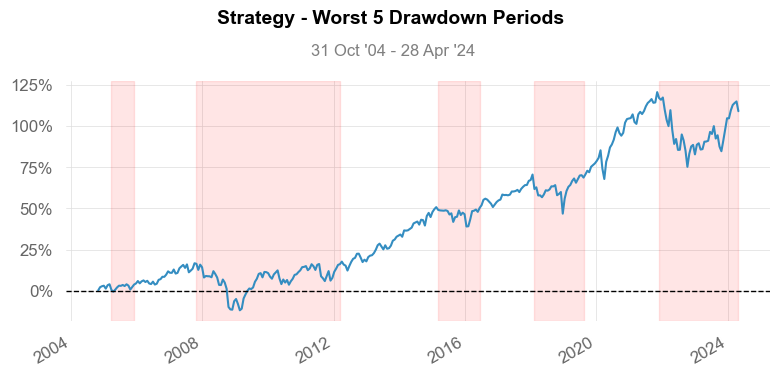

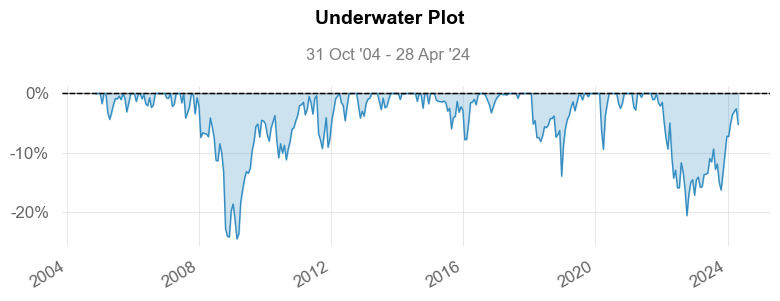

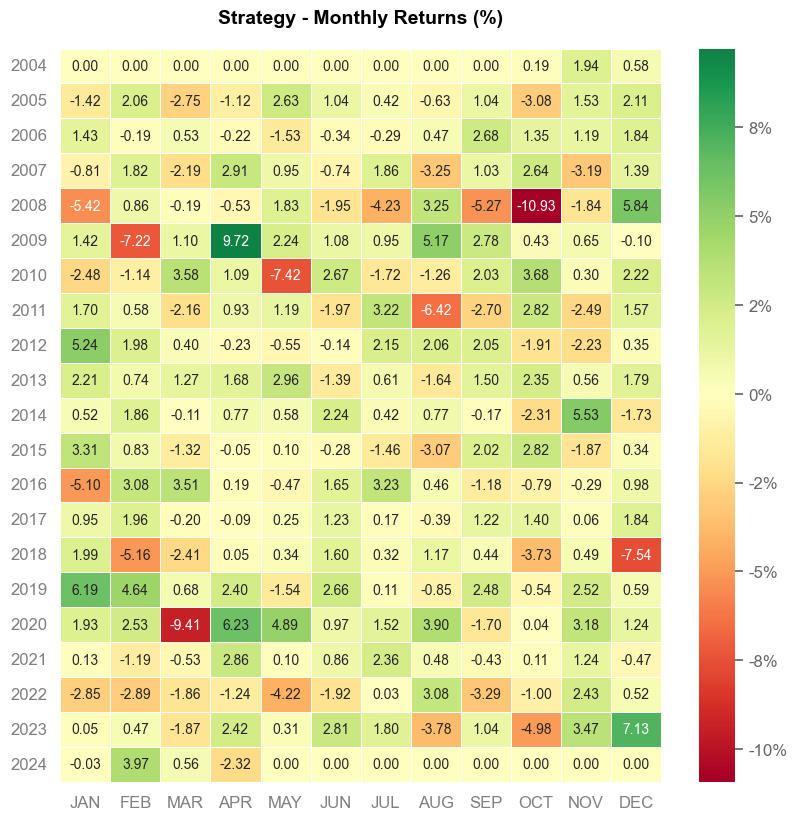

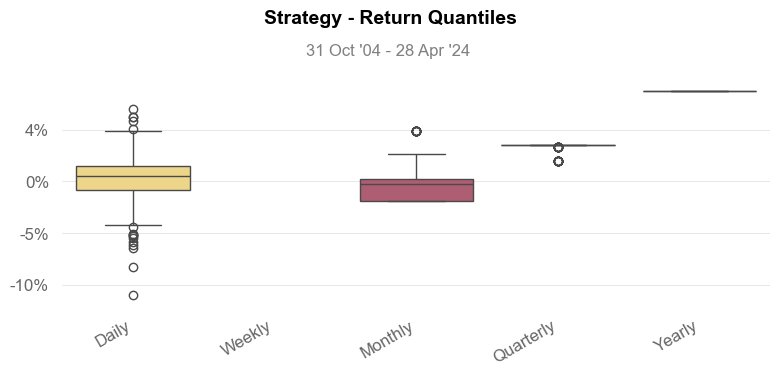

In [ ]:
#%%

qs.reports.full(portfolio_df['value'].pct_change())